In [1]:
# Potrebno za Google Colab

#! unzip UniProt\ cist.zip
#! mkdir ../data
#! mv UniProt\ cist ../data/
#! pip install biopython
#! mkdir ../data/Rezultati_Uniprot_cist


In [2]:
import os
import sys
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn import preprocessing as prep
from sklearn import model_selection as ms
from sklearn import linear_model as lm
from sklearn import metrics as met
from sklearn import svm
from sklearn import utils
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

%matplotlib inline
#plt.style.use ('dark_background')
#utils.parallel_backend ('multiprocessing')
#utils.parallel_backend ('loky')


Using TensorFlow backend.


#### Kratak uvod vezan za koriscene podatke
* Podaci korisceni u ovom radu su preuzeti sa zvanicnog sajta UniProt baze podataka
* Svi podaci zapravo predstavljaju FASTA sekvence svih dostupnih proteina za organizam Arabidopsis Thaliana
* Prvo su skinuti proteini za koje je poznato mesto glikozilacije i kojih je 1863, a zatim i ostali proteini tog organizma tj. oni za koje se smatra da nemaju mesto za potencijalnu glikozilaciju
* To je ucinjeno pomocu upita koji izdvaja proteine sa poznatim mestom glikozilacije i koji je kreiran pomocu 'Advanced' polja, desno od polja za pretragu te je link sa rezultatima upita

<https://www.uniprot.org/uniprot/?query=annotation:(type:carbohyd "n linked")&fil=reviewed%3Ayes+AND+organism%3A"Arabidopsis+thaliana+(Mouse-ear+cress)+[3702]"&sort=score>
* Samim tim skup proteina za koje se smatra da nemaju mesto glikozilacije predstavlja citav skup proteina ovog organizma bez gore navedenog skupa i on sadrzi 13974 proteina.

In [3]:
#######################################################################################################################
# Ova celija je namenjena za koriscenje samo onda kada je potrebno masinskim ucenjem naci poziciju unutar proteina
# gde ce se potencijalno desiti glikozilacija, ili vratiti da takva pozicija ne postoji
# Samim tim, ova celija za sad NIJE POTREBNA, jer mi je za sada cilj samo napraviti model koji ce odredjivati
# da ce se mozda desiti glikozilacija na proteinu ili ne, tj. resavam klasifikacioni problem.
# Prethodni problem sa nalazenjem pozicije predstavlja regresioni problem
#######################################################################################################################

# Prolazak kroz pozitivne proteine i izvlacenje pozicija glikozilacije iz trece kolone,
# a zatim cuvanje tako kreiranog fajla sa izmenjenom trecom kolonom
# Treca kolona ce biti u obliku: pozicija[, pozicija]*
def sredi_pozicije_glikozilacije():
    
    df_poz = pd.read_csv (os.path.join ('..', 'data', 'UniProt cist', 'Pozitivni', 'EXCEL.csv'), sep = '\t')
    kolone = df_poz.columns.values
    
    # Lista koja sadrzi niz pozicija za svaki protein u obliku pozicija[, pozicija]*
    lista_pozicija = []

    for niska in niz_niski:
        # U svakoj niski odvajam delove koji sadrze razlicite pozicije (jedan protein moze da ima vise pozicija na kojima se vrsi glikozilacija)
        niske = niska.split (';')

        # Lista koja sadrzi niz pozicija za jedan protein
        tmp_lista = []

        # Prolazim kroz tako dobijenu listu niski, izvlacim pozicije i kreiram listu pozicija za sve proteine
        for niska_poz in niske:

            # Potrebno ovako jer postoji i unos (moza i vise njih) koji u sebi sadrzi ';' te se pojavljuje string koji predstavlja deo unosa koji ne sadrzi nikakav broj te se javlja greska
            tmp_lista.append ([int (c) for c in niska_poz.split() if c.isdigit()][0] if len ([int (c) for c in niska_poz.split() if c.isdigit()]) > 0 else '')

        lista_pozicija.append (', '.join (str(d) for d in tmp_lista))
    
    # Kreiranje Series objekta koji ce da predstavlja novu trecu kolonu
    nova_kolona = pd.Series (lista_pozicija, name = 'Glycosylation positions')
    
    # Ostaje jos da se nova kolona sjedini sa prethodnim podacima iz prve dve kolone
    # Pravimo novi DataFrame koji kasnije cuvamo kao novi .csv fajl

    df_novi_poz = pd.DataFrame(pd.concat ([df_poz['Entry'], df_poz['Entry name'], nova_kolona], axis = 1), columns = [kolone[0], kolone[1], 'Glycosylation positions'])
    df_novi_poz.to_csv (os.path.join ('..', 'data', 'UniProt cist', 'Pozitivni', 'POZ_EXCEL_izmenjen.csv'), sep = '\t')


# 1. Priprema podataka
## 1.1 Eliminisanje proteina koji imaju nepoznatu (neodredjenu) amino-kiselinu unutar svoje FASTA sekvence

In [4]:
# Neke FASTA sekence mogu sadrzati nepoznate amino-kiseline ili mesto gde moze doci bilo koja amino-kiselina (u oba slucaja se obelezava sa 'X')
# Potrebno je dakle eleminisati takve sekvence, a samim tim i takve proteine iz baze podataka
# Specijalno, u mom slucaju se to desilo kod skupa 'negativnih' proteina, ali pravim genericku funkciju koja to moze da obradi

# Prvo se prolazi jednom kroz FASTA fajl i pamte redni brojevi proteina koji sadrze nepoznate amino-kiselina
# Zatim se na osnovu tako dobijene liste rednih brojeva, uklanjaju proteini iz .csv i .fasta fajla i kreiraju novi fajlovi bez njih
def eliminisi_nepoznate (putanja, klasa):
    
    # Prvo ucitavamo FASTA fajl
    ostatak_ulaza_fasta = 'POZ_FASTA.fasta' if klasa == 1 else 'NEG_FASTA.fasta'
    fasta_niske = SeqIO.parse (os.path.join (putanja, ostatak_ulaza_fasta), 'fasta')
    
    i = 0
    lista_rednih_br = []
    
    for fasta_niska in fasta_niske:
        sekvenca = str(fasta_niska.seq)
        
        if 'X' in sekvenca:
            lista_rednih_br.append(i)
        
        i += 1
    
    # Ispisivanje liste za potrebe debagovanja
    print (lista_rednih_br)
    
    # Cuvanje fajlova sa novim imenom oblika: OB_staroime, gde je OB od obradjeno
    
    ostatak_izlaza_fasta = 'OB_POZ_FASTA.fasta' if klasa == 1 else 'OB_NEG_FASTA.fasta'
    
    with open(os.path.join (putanja, ostatak_izlaza_fasta), 'w') as fajl_izlaz:
        with open(os.path.join (putanja, ostatak_ulaza_fasta), 'r') as fajl_ulaz:
                
                j = 0
                for fasta_niska in SeqIO.parse(fajl_ulaz, "fasta"):
                    # Ako smo dosli do sekvence koja sadrzi nepoznatu amino-kiselinu, onda je ne upisujemo u izlaz
                    if j in lista_rednih_br:
                        j += 1
                        continue
                        
                    else:
                        j += 1
                        r = SeqIO.write(fasta_niska, fajl_izlaz, 'fasta')
                        
                        if r != 1:
                            print('Greska pri upisivanju sekvence ' + fasta_niska.id + ' na poziciji ' + j)
    
    
    # Isto ovo je potrebno i za .csv datoteke
    ostatak_ulaza_csv = 'POZ_EXCEL.csv' if klasa == 1 else 'NEG_EXCEL.csv'
    df_obradjen = pd.read_csv (os.path.join (putanja, ostatak_ulaza_csv), sep = '\t')
    
    # Izbacivanje redova tj. proteina koji sadrze nepoznate amino-kiseline
    df_obradjen = df_obradjen.drop (lista_rednih_br)
    df_obradjen = df_obradjen.reset_index (drop = True)
    
    # Cuvanje obradjenog DataFrame-a
    ostatak_izlaza_csv = 'OB_POZ_EXCEL.csv' if klasa == 1 else 'OB_NEG_EXCEL.csv'
    df_obradjen.to_csv(os.path.join (putanja, ostatak_izlaza_csv), sep = '\t')


In [5]:
# Obrada polaznih podataka koriscenjem prethodne funkcije

poz_putanja = os.path.join ('..', 'data', 'UniProt cist', 'Pozitivni')
neg_putanja = os.path.join ('..', 'data', 'UniProt cist', 'Negativni')

eliminisi_nepoznate (poz_putanja, 1)
eliminisi_nepoznate (neg_putanja, 0)


[]
[8277, 8625]


## 1.2 Dobijanje fizicko-hemijskih karakteristika svakog od proteina
Koriscenje BioPython biblioteke za dobijanje prvih sest osobina, dok se za ostale osobine koriste uputstva sa sajta: https://github.com/SBRG/Protein_ML

In [6]:
# Obrada FASTA fajlova, tj. citavih sekvenci proteina zarad dobijanja fizicko-hemijskih karakteristika svakog od njih pomocu BioPython biblioteke
# Za pocetak, na osnovu ovih karakteristika cu probati da saznam da li ce protein biti glikozilizovan
# ili ne. Dalji rad bi mogao da bude nalazenje pozicija (prozora) na kojima se desava glikozilacija

# Kreiramo liste vrednosti za svaku od osobina koje mozemo da sracunamo. Nakon sracunavanja, kreiramo
# Series objekte koje zatim nadovezujemo i pravimo novi DataFrame objekat za cuvanje
# Nije najefikasniji nacin dobijanja rezultata (u Python smislu), ali je najpregledniji


def napravi_osobine (putanja, indeksi, klasa):
    
    niz_osobina_0 = []  # Molekularna tezina
    niz_osobina_1 = []  # Gravy
    niz_osobina_2 = []  # Aromaticnost
    niz_osobina_3 = []  # Indeks nestabilnosti
    niz_osobina_4 = []  # Udeo amino-kiselina
    niz_osobina_5 = []  # Isoelektricna tacka
    niz_osobina_6 = []  # Udeo sekundarne strukture

    niz_osobina_7 = []  # Naelektrisanje 
    niz_osobina_8 = []  # Apsolutno naelektrisanje
    niz_osobina_9 = []  # Prosecno naelektrisanje
    niz_osobina_10 = []  # Apsolutno prosecno naelektrisanje

    niz_osobina_11 = []  # Udeo alifatickih amino-kiselina
    niz_osobina_12 = []  # Udeo nenaelektrisanih polarnih amino-kiselina
    niz_osobina_13 = []  # Udeo polarnih amino-kiselina
    niz_osobina_14 = []  # Udeo hidrofobnih amino-kiselina
    niz_osobina_15 = []  # Udeo pozitivnih amino-kiselina
    niz_osobina_16 = []  # Udeo sumpurnih amino-kiselina
    niz_osobina_17 = []  # Udeo negativnih amino-kiselina
    niz_osobina_18 = []  # Udeo amidnih amino-kiselina
    niz_osobina_19 = []  # Udeo alkoholnih amino-kiselina
    
    niz_osobina_20 = []  # Postojanje Asn–X–Ser/Thr (N-X-S/T) trojke AK, gde je X bilo koja AK sem prolina (Pro) - vrednosti 0 ili 1
    niz_osobina_21 = []  # Tacan broj Asn–X–Ser/Thr (N-X-S/T) trojki AK, gde je X bilo koja AK sem prolina (Pro) - vrednosti 0, 1, 2, 3...
    
    reg_izraz = r'N[^P][ST][^P]'  # Kreiranje regularnog izraza koji definise N-vezanu glikozilaciju
    
    # Prvo ucitavamo FASTA fajl
    ostatak_putanje = 'OB_POZ_FASTA.fasta' if klasa == 1 else 'OB_NEG_FASTA.fasta'
    
    with open(os.path.join (putanja, ostatak_putanje), 'r') as fajl_ulaz:
        for fasta_niska in SeqIO.parse(fajl_ulaz, "fasta"):

            sekvenca = str(fasta_niska.seq)
            analiza_sekvence = ProteinAnalysis (sekvenca)

            niz_osobina_0.append (analiza_sekvence.molecular_weight())
            niz_osobina_1.append (analiza_sekvence.gravy())
            niz_osobina_2.append (analiza_sekvence.aromaticity())
            niz_osobina_3.append (analiza_sekvence.instability_index())
            udeo_amino_kiselina = analiza_sekvence.get_amino_acids_percent()
            niz_osobina_4.append (udeo_amino_kiselina)
            niz_osobina_5.append (analiza_sekvence.isoelectric_point())
            niz_osobina_6.append (analiza_sekvence.secondary_structure_fraction())

            naelektrisanje = sekvenca.count ('K') + sekvenca.count ('R') - sekvenca.count ('D') - sekvenca.count ('E')
            niz_osobina_7.append (naelektrisanje)
            niz_osobina_8.append (abs (naelektrisanje))
            niz_osobina_9.append (naelektrisanje / len (sekvenca))
            niz_osobina_10.append (abs (naelektrisanje / len (sekvenca)))

            niz_osobina_11.append (sum ([udeo_amino_kiselina[ak] for ak in 'AGILPV']))
            niz_osobina_12.append (sum ([udeo_amino_kiselina[ak] for ak in 'STNQ']))
            niz_osobina_13.append (sum ([udeo_amino_kiselina[ak] for ak in 'QNHSTYCMW']))
            niz_osobina_14.append (sum ([udeo_amino_kiselina[ak] for ak in 'AGILPVF']))
            niz_osobina_15.append (sum ([udeo_amino_kiselina[ak] for ak in 'HKR']))
            niz_osobina_16.append (sum ([udeo_amino_kiselina[ak] for ak in 'CM']))
            niz_osobina_17.append (sum ([udeo_amino_kiselina[ak] for ak in 'DE']))
            niz_osobina_18.append (sum ([udeo_amino_kiselina[ak] for ak in 'NQ']))
            niz_osobina_19.append (sum ([udeo_amino_kiselina[ak] for ak in 'ST']))
            
            # Trazimo motiv u oba slucaja, jer postojanje motiva ne znaci i da je protein pozitivan
            # I negativni proteini mogu da imaju motiv, ali ne znaci da ce biti glikozilovani
            
            rez_lista = re.findall (reg_izraz, sekvenca)
            duzina_liste = len (rez_lista)
            niz_osobina_20.append (int(duzina_liste > 0))
            niz_osobina_21.append (duzina_liste)

    
    # Za prosledjen FASTA fajl su napravljene osobine. Treba samo paziti pri ubacivanju frekvencije
    # amino-kiselina (jer je to mapa) i secondary_structure_fraction (jer je to trojka), dakle za njih
    # treba napraviti posebne kolone tj. treba ih izdeliti

    # Sredjivanje frekvencija amino-kiselina (20 novih kolona, za svaku amino-kiselinu) i
    # secondary_structure_fraction (3 nove kolone, za svaku osobinu).
    
    mapa_finalna = {}

    mapa_finalna['Molekularna tezina'] = niz_osobina_0
    mapa_finalna['Gravy'] = niz_osobina_1
    mapa_finalna['Aromaticnost'] = niz_osobina_2
    mapa_finalna['Indeks nestabilnosti'] = niz_osobina_3

    # Za svaku amino-kiselinu po nova kolona sa njenim udelom u celoj sekvenci
    for ak in list(niz_osobina_4[0].keys()):
        
        lista_udela_za_jednu_ak = []
        for mapa in niz_osobina_4:
            lista_udela_za_jednu_ak.append (mapa[ak])
        
        mapa_finalna['Udeo "' + str(ak) + '" u proteinu'] = lista_udela_za_jednu_ak

    mapa_finalna['Izoelektricna tacka'] = niz_osobina_5
    
    mapa_finalna['Udeo ak. u heliksu'] = []
    mapa_finalna['Udeo ak. u zavoju'] = []
    mapa_finalna['Udeo ak. u ravni'] = []
    
    for trojka in niz_osobina_6:
        mapa_finalna['Udeo ak. u heliksu'].append (trojka[0])
        mapa_finalna['Udeo ak. u zavoju'].append (trojka[1])
        mapa_finalna['Udeo ak. u ravni'].append (trojka[2])

    mapa_finalna['Naelektrisanje'] = niz_osobina_7
    mapa_finalna['Apsolutno naelektrisanje'] = niz_osobina_8
    mapa_finalna['Prosecno naelektrisanje'] = niz_osobina_9
    mapa_finalna['Apsolutno prosecno naelektrisanje'] = niz_osobina_10

    mapa_finalna['Udeo alifatickih ak.'] = niz_osobina_11
    mapa_finalna['Udeo nenaelektrisanih polarnih ak.'] = niz_osobina_12
    mapa_finalna['Udeo polarnih ak.'] = niz_osobina_13
    mapa_finalna['Udeo hidrofobnih ak.'] = niz_osobina_14
    mapa_finalna['Udeo pozitivnih ak.'] = niz_osobina_15
    mapa_finalna['Udeo sumpornih ak.'] = niz_osobina_16
    mapa_finalna['Udeo negativnih ak.'] = niz_osobina_17
    mapa_finalna['Udeo amidnih ak.'] = niz_osobina_18
    mapa_finalna['Udeo alkoholnih ak.'] = niz_osobina_19
    
    # Unos kolona o postojanju i broju motiva glikozilacije
    mapa_finalna['Postojanje glikozilacije'] = niz_osobina_20
    mapa_finalna['Broj mesta glikozilacije'] = niz_osobina_21
    
    mapa_finalna['Klasa'] = [klasa for i in range (len (niz_osobina_0))]

    # Kreiranje DataFrame-a
    df_finalni = pd.DataFrame (mapa_finalna, index = indeksi)
    
    # Cuvanje DataFrame-a u .csv formatu
    ime_izlaza = 'POZ_FINALNO.csv' if klasa == 1 else 'NEG_FINALNO.csv'
    df_finalni.to_csv (os.path.join (putanja, ime_izlaza), sep = '\t')
    
    return df_finalni


In [7]:
# Testiranje funkcija

poz_putanja = os.path.join ('..', 'data', 'UniProt cist', 'Pozitivni')
df_poz = pd.read_csv (os.path.join (poz_putanja, 'OB_POZ_EXCEL.csv'), sep = '\t')
poz_indeksi = df_poz['Entry'].values
poz_klasa = 1

neg_putanja = os.path.join ('..', 'data', 'UniProt cist', 'Negativni')
df_neg = pd.read_csv (os.path.join (neg_putanja, 'OB_NEG_EXCEL.csv'), sep = '\t')
neg_indeksi = df_neg['Entry'].values
neg_klasa = 0

# Pravljenje osobina i za pozitivne i za negativne skupove
df_poz_finalni = napravi_osobine (poz_putanja, poz_indeksi, poz_klasa)
df_neg_finalni = napravi_osobine (neg_putanja, neg_indeksi, neg_klasa)


In [8]:
# Izgled pozitivnih
df_poz_finalni

,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu",...,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9SSS9,25668.2531,-0.049145,0.051282,42.751709,0.098291,0.000000,0.047009,0.055556,0.038462,0.034188,...,0.316239,0.465812,0.119658,0.021368,0.102564,0.119658,0.158120,1,1,1
O04151,48526.7256,-1.009412,0.105882,31.455082,0.072941,0.007059,0.120000,0.122353,0.037647,0.051765,...,0.258824,0.367059,0.148235,0.016471,0.242353,0.051765,0.105882,1,3,1
Q9LV16,77740.2127,-0.460206,0.091043,42.948752,0.046990,0.017621,0.048458,0.080764,0.042584,0.058737,...,0.320117,0.409692,0.168869,0.041116,0.129222,0.064611,0.138032,1,1,1
Q9SE50,60458.5342,-0.509659,0.140152,26.184129,0.053030,0.015152,0.070076,0.051136,0.058712,0.089015,...,0.329545,0.433712,0.157197,0.030303,0.121212,0.077652,0.098485,1,3,1
Q9SYQ8,107596.6100,0.019184,0.077551,30.612449,0.047959,0.014286,0.039796,0.057143,0.046939,0.087755,...,0.319388,0.497959,0.114286,0.035714,0.096939,0.089796,0.134694,1,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9SU13,43447.8938,-0.076179,0.071960,38.811166,0.091811,0.007444,0.074442,0.029777,0.039702,0.059553,...,0.342432,0.459057,0.116625,0.029777,0.104218,0.076923,0.181141,1,4,1
Q3E9A4,53221.7554,-0.192275,0.100858,62.873433,0.060086,0.010730,0.036481,0.055794,0.049356,0.040773,...,0.334764,0.459227,0.156652,0.038627,0.092275,0.079399,0.122318,1,3,1
O80522,40476.1001,0.070000,0.105405,31.570270,0.062162,0.027027,0.045946,0.029730,0.059459,0.097297,...,0.345946,0.497297,0.108108,0.054054,0.075676,0.091892,0.127027,1,2,1
F4HTM3,97633.0234,-0.361620,0.119718,40.480423,0.036385,0.004695,0.061033,0.056338,0.049296,0.079812,...,0.330986,0.434272,0.143192,0.026995,0.117371,0.077465,0.130282,1,6,1


In [9]:
# Izgled negativnih
df_neg_finalni

,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu",...,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
F4I443,79689.1581,-0.586975,0.061625,48.451849,0.070028,0.036415,0.061625,0.071429,0.025210,0.047619,...,0.359944,0.380952,0.156863,0.054622,0.133053,0.091036,0.147059,1,3,0
Q8RXD3,34806.9132,-0.550968,0.064516,54.291645,0.061290,0.029032,0.048387,0.116129,0.029032,0.051613,...,0.319355,0.406452,0.135484,0.048387,0.164516,0.083871,0.125806,0,0,0
P04778,28240.8071,0.020974,0.108614,24.637828,0.123596,0.003745,0.041199,0.056180,0.059925,0.123596,...,0.254682,0.565543,0.093633,0.029963,0.097378,0.052434,0.112360,0,0,0
Q9FLD5,60346.9487,-0.847276,0.095331,51.946342,0.042802,0.007782,0.062257,0.128405,0.042802,0.046693,...,0.284047,0.342412,0.200389,0.031128,0.190661,0.062257,0.120623,1,3,0
Q9M022,28049.1504,-0.364463,0.099174,52.350455,0.057851,0.041322,0.061983,0.070248,0.033058,0.045455,...,0.314050,0.404959,0.169421,0.061983,0.132231,0.057851,0.107438,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8RXF8,72321.5750,-0.249228,0.081790,52.203410,0.086420,0.020062,0.066358,0.075617,0.046296,0.050926,...,0.280864,0.461420,0.126543,0.040123,0.141975,0.070988,0.123457,1,1,0
P93282,13248.7403,-0.405785,0.049587,44.333884,0.057851,0.016529,0.049587,0.049587,0.016529,0.016529,...,0.438017,0.371901,0.107438,0.041322,0.099174,0.066116,0.280992,1,1,0
Q9LJK3,34698.4268,0.412500,0.175676,31.229764,0.081081,0.020270,0.054054,0.043919,0.077703,0.040541,...,0.314189,0.489865,0.121622,0.057432,0.097973,0.030405,0.104730,0,0,0
Q9ASU8,38178.9715,0.116570,0.084302,43.015116,0.061047,0.031977,0.037791,0.063953,0.029070,0.072674,...,0.337209,0.479651,0.101744,0.072674,0.101744,0.063953,0.125000,0,0,0


In [10]:
# Primetivo je da su klase nebalansirane, tj. imamo skoro 7 puta vise proteina koji su negativni
# Sa time se treba izboriti u delu treniranja modela masinskog ucenja


# Sledece treba vizualizovati podatke. Probati sa matricom korelacije
# Zatim se treba izboriti sa neizbalansiranoscu
# Na kraju natrenirati model i proveriti uspesnost


## 1.3 Vizualizacija podataka i sracunatih osobina za lakse razumevanje problema

In [11]:
# Krecemo sa ucitavanjem podataka i vizualizacijom istih
poz_putanja_ulaza = os.path.join ('..', 'data', 'UniProt cist', 'Pozitivni', 'POZ_FINALNO.csv')
neg_putanja_ulaza = os.path.join ('..', 'data', 'UniProt cist', 'Negativni', 'NEG_FINALNO.csv')

df_poz = pd.read_csv (poz_putanja_ulaza, sep = '\t', index_col = 0)
df_neg = pd.read_csv (neg_putanja_ulaza, sep = '\t', index_col = 0)


In [12]:
# Kreiranje DataFrame-a koji sadrzi i pozitivne i negativne proteine
# verify_integrity parametar obezbedjuje proveru jedinstvenosti indeksa
# Samim tim se zapravo vidi da nema preklapanja iz pozitivnih i negativnih skupova podataka

df_sve = pd.concat([df_poz,df_neg], ignore_index=False, verify_integrity = True)
df_sve


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu",...,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9SSS9,25668.2531,-0.049145,0.051282,42.751709,0.098291,0.000000,0.047009,0.055556,0.038462,0.034188,...,0.316239,0.465812,0.119658,0.021368,0.102564,0.119658,0.158120,1,1,1
O04151,48526.7256,-1.009412,0.105882,31.455082,0.072941,0.007059,0.120000,0.122353,0.037647,0.051765,...,0.258824,0.367059,0.148235,0.016471,0.242353,0.051765,0.105882,1,3,1
Q9LV16,77740.2127,-0.460206,0.091043,42.948752,0.046990,0.017621,0.048458,0.080764,0.042584,0.058737,...,0.320117,0.409692,0.168869,0.041116,0.129222,0.064611,0.138032,1,1,1
Q9SE50,60458.5342,-0.509659,0.140152,26.184129,0.053030,0.015152,0.070076,0.051136,0.058712,0.089015,...,0.329545,0.433712,0.157197,0.030303,0.121212,0.077652,0.098485,1,3,1
Q9SYQ8,107596.6100,0.019184,0.077551,30.612449,0.047959,0.014286,0.039796,0.057143,0.046939,0.087755,...,0.319388,0.497959,0.114286,0.035714,0.096939,0.089796,0.134694,1,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8RXF8,72321.5750,-0.249228,0.081790,52.203410,0.086420,0.020062,0.066358,0.075617,0.046296,0.050926,...,0.280864,0.461420,0.126543,0.040123,0.141975,0.070988,0.123457,1,1,0
P93282,13248.7403,-0.405785,0.049587,44.333884,0.057851,0.016529,0.049587,0.049587,0.016529,0.016529,...,0.438017,0.371901,0.107438,0.041322,0.099174,0.066116,0.280992,1,1,0
Q9LJK3,34698.4268,0.412500,0.175676,31.229764,0.081081,0.020270,0.054054,0.043919,0.077703,0.040541,...,0.314189,0.489865,0.121622,0.057432,0.097973,0.030405,0.104730,0,0,0
Q9ASU8,38178.9715,0.116570,0.084302,43.015116,0.061047,0.031977,0.037791,0.063953,0.029070,0.072674,...,0.337209,0.479651,0.101744,0.072674,0.101744,0.063953,0.125000,0,0,0


In [13]:
# Permutovanje vrsta ovakvog DataFrame-a tako da nemamo prvo pozitivne pa negativne, vec proizvoljno
df_sve = df_sve.reindex (np.random.permutation (df_sve.index))
df_sve


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu",...,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9FLA2,50376.0372,0.013014,0.093607,47.479247,0.022831,0.015982,0.063927,0.057078,0.052511,0.038813,...,0.321918,0.452055,0.130137,0.045662,0.121005,0.075342,0.134703,1,1,0
O81862,41127.5342,-0.098945,0.131926,33.980792,0.110818,0.007916,0.050132,0.013193,0.047493,0.073879,...,0.403694,0.456464,0.087071,0.021108,0.063325,0.079156,0.208443,1,2,1
Q8LD98,28573.8214,-0.255556,0.091270,44.644087,0.047619,0.031746,0.027778,0.039683,0.051587,0.051587,...,0.349206,0.448413,0.150794,0.043651,0.067460,0.111111,0.138889,1,4,1
O81028,90359.4141,-0.004380,0.087610,32.720038,0.071339,0.030038,0.051314,0.082603,0.047559,0.058824,...,0.284105,0.455569,0.136421,0.068836,0.133917,0.072591,0.092616,1,5,0
Q9SB63,153685.6327,-1.236402,0.053824,53.942861,0.066572,0.002125,0.043909,0.066572,0.019830,0.102691,...,0.406516,0.354816,0.161473,0.019122,0.110482,0.135269,0.184844,1,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q94AY3,47189.2995,-0.700714,0.045238,62.142619,0.054762,0.026190,0.057143,0.076190,0.023810,0.045238,...,0.321429,0.371429,0.195238,0.040476,0.133333,0.069048,0.169048,1,3,0
Q9LY74,37926.2571,-0.268047,0.106509,40.710385,0.062130,0.011834,0.056213,0.047337,0.047337,0.076923,...,0.286982,0.482249,0.147929,0.032544,0.103550,0.050296,0.124260,1,1,0
F4I8U2,53334.5501,-0.144538,0.079832,40.837206,0.058824,0.016807,0.056723,0.054622,0.035714,0.071429,...,0.329832,0.436975,0.144958,0.046218,0.111345,0.075630,0.140756,1,5,0
Q9LFT8,56728.4952,-0.819802,0.091089,44.201802,0.053465,0.011881,0.041584,0.055446,0.031683,0.104950,...,0.330693,0.447525,0.162376,0.031683,0.097030,0.116832,0.085149,1,4,0


In [14]:
# Izdvajanje poslednje kolone, koja predstavlja klasu kojoj protein pripada i izbacivanje iste iz DataFrame-a
y = df_sve['Klasa'].values
df_sve = df_sve.drop (labels = ['Klasa'], axis = 1)


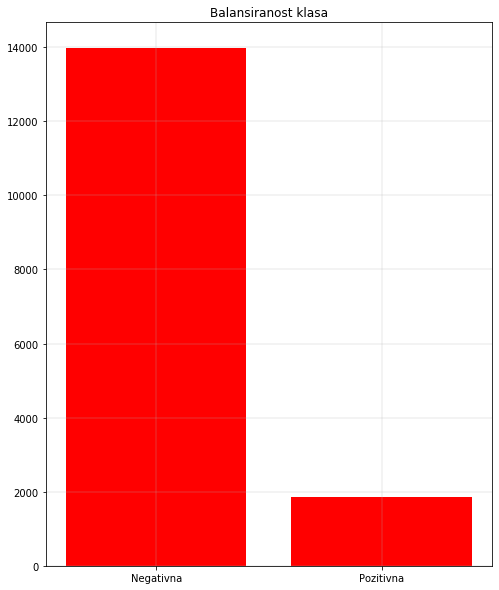

In [15]:
# Prvo da vizualizujemo u kakvom su odnosu klase

fig = plt.figure (figsize = (8, 10))
plt.title ('Balansiranost klasa')
plt.xticks (ticks = range (2), labels = ['Negativna', 'Pozitivna'])
plt.bar ([0, 1], [sum(y == 0), sum (y == 1)], color = 'red')
plt.grid (linewidth = 0.3)
plt.show()


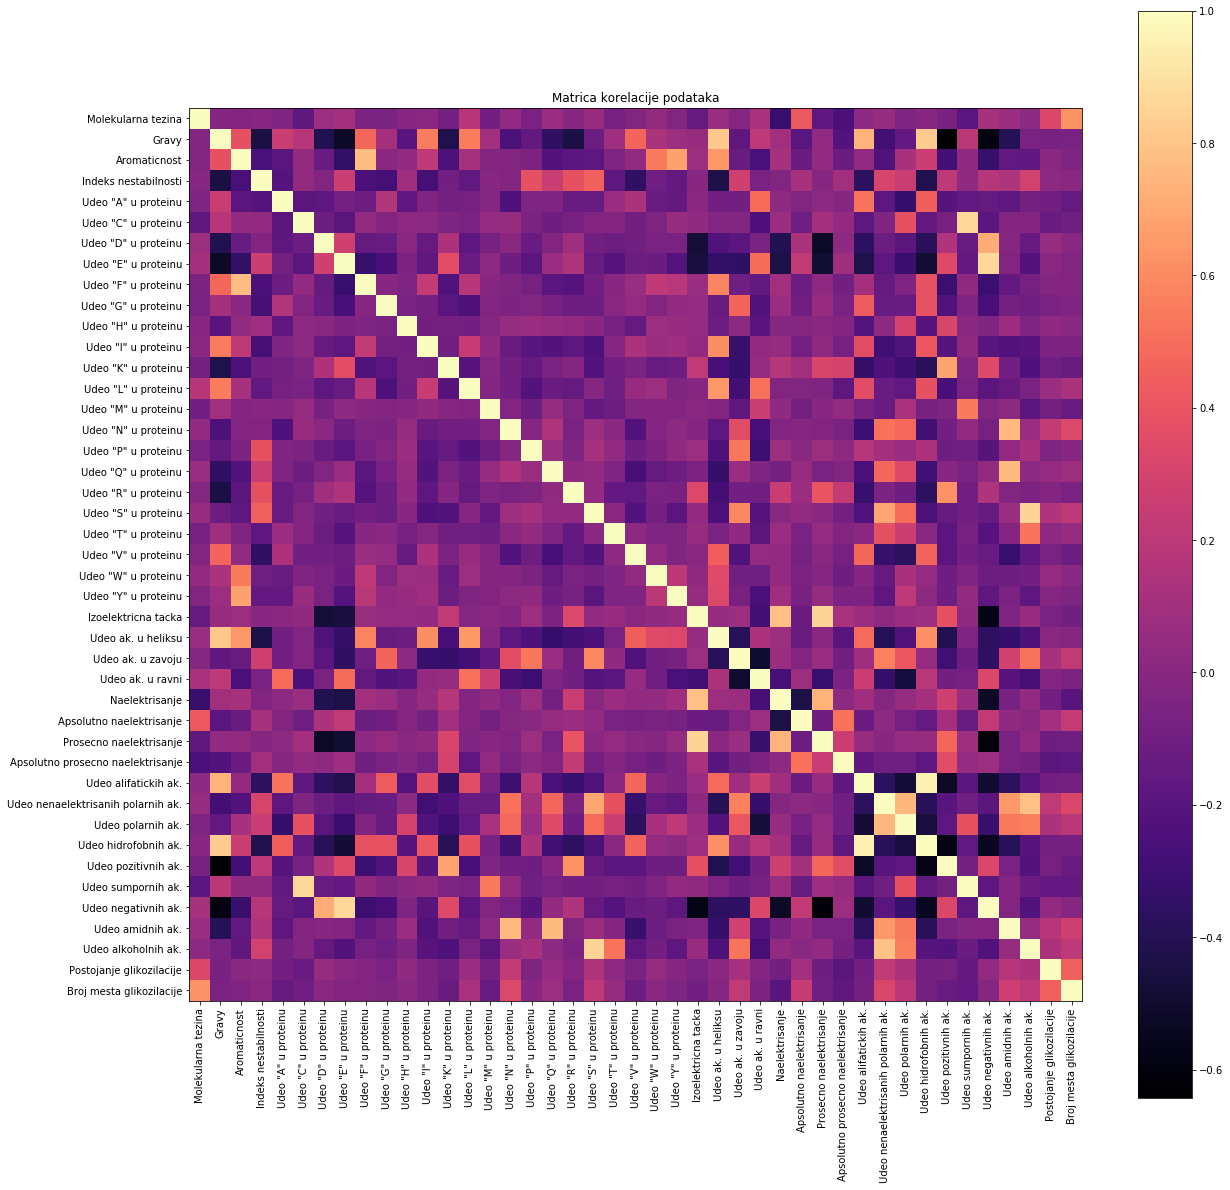

In [16]:
# Vizualizacija podataka pomocu matrice korelacije
kolone = df_sve.columns.values

fig = plt.figure (figsize = (20, 20))
plt.title ('Matrica korelacije podataka')
plt.xticks (ticks = range (len (kolone)), labels = kolone, rotation = 90)
plt.yticks (ticks = range (len (kolone)), labels = kolone)
plt.imshow (df_sve.corr(), cmap = 'magma')
plt.colorbar()
plt.show()

# Vidimo da nije velika korelisanost podataka ni u jednom delu, sto je jako dobro


# 2. Neposredna priprema podataka zarad ispravne primene modela masinskog ucenja
## 2.1 Deljenje na skupove za trening i test

Broj proteina u x_trening skupu podataka:  (10610, 43)
Broj proteina u y_trening skupu podataka:  (10610,)
Broj proteina u x_test skupu podataka:  (5227, 43)
Broj proteina u y_test skupu podataka:  (5227,)


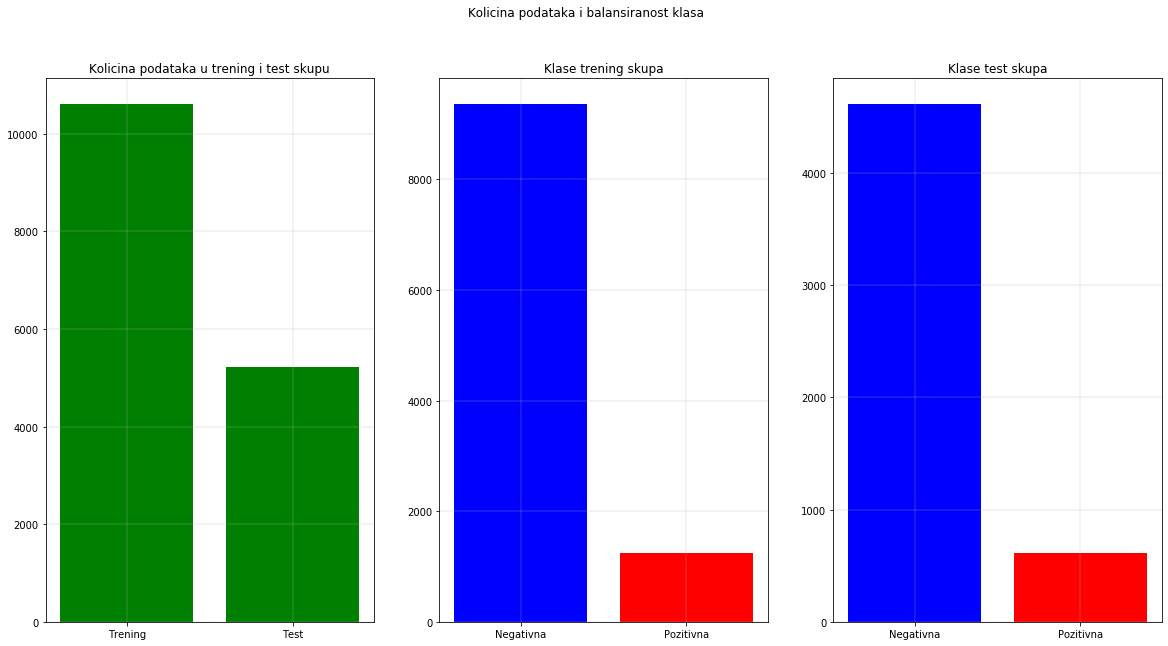

In [17]:
# Deljenje podataka na skupove za trening i test, 2:1 odnos
# Bitan parametar predstavlja i stratifikacija po klasi, tako da imamo ujednaceno deljenje na skupove (tj. balansiranost klasa po skupovima)
X = df_sve.values

x_trening, x_test, y_trening, y_test = ms.train_test_split (X, y, train_size = 0.67, test_size = 0.33, stratify = y, random_state = 7)

# Standardizacija podataka
skaler = prep.StandardScaler()
skaler.fit (x_trening)
x_trening = skaler.transform (x_trening)
x_test = skaler.transform (x_test)

print ('Broj proteina u x_trening skupu podataka: ', x_trening.shape)
print ('Broj proteina u y_trening skupu podataka: ', y_trening.shape)
print ('Broj proteina u x_test skupu podataka: ', x_test.shape)
print ('Broj proteina u y_test skupu podataka: ', y_test.shape)

# Vizualizacija podele na trening i test skup i balansiranosti klasa

fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize = (20, 10))
plt.suptitle ('Kolicina podataka i balansiranost klasa')

ax1.set_title ('Kolicina podataka u trening i test skupu')
ax1.set_xticks (ticks = range (2))
ax1.set_xticklabels (labels = ['Trening', 'Test'])
ax1.bar ([0, 1], [x_trening.shape[0], x_test.shape[0]], color = 'green')
ax1.grid (linewidth = 0.3)

ax2.set_title ('Klase trening skupa')
ax2.set_xticks (ticks = range (2))
ax2.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax2.bar ([0, 1], [sum(y_trening == 0), sum (y_trening == 1)], color = ['blue', 'red'])
ax2.grid (linewidth = 0.3)

ax3.set_title ('Klase test skupa')
ax3.set_xticks (ticks = range (2))
ax3.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax3.bar ([0, 1], [sum(y_test == 0), sum (y_test == 1)], color = ['blue', 'red'])
ax3.grid (linewidth = 0.3)

plt.show()


## 2.2 Balansiranje podataka nasumicnim podsempliranjem (pomocu _imblearn_ biblioteke)

In [69]:
# Balansiranje podataka podsempliranjem (nasumicnim podsemplerom) i cuvanje novih podataka (radi se samo za trening skup!)

print ('Broj pozitivnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 1))
print ('Broj negativnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 0))

pod_sempler = RandomUnderSampler(random_state = 7)
x_trening_pod, y_trening_pod = pod_sempler.fit_sample (x_trening, y_trening)

print ('Izgled x_trening skupa nakon podsempliranja:', x_trening_pod.shape)
print ('Izgled y_trening skupa nakon podsempliranja:', y_trening_pod.shape)

print ('Broj pozitivnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_pod == 1))
print ('Broj negativnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_pod == 0))


Broj pozitivnih proteina trening skupa, pre balansiranja:  1248
Broj negativnih proteina trening skupa, pre balansiranja:  9362
Izgled x_trening skupa nakon podsempliranja: (2496, 43)
Izgled y_trening skupa nakon podsempliranja: (2496,)
Broj pozitivnih proteina trening skupa, nakon balansiranja:  1248
Broj negativnih proteina trening skupa, nakon balansiranja:  1248


## 2.3 Balansiranje podataka nadsempliranjem SMOTE algoritmom

In [70]:
# Balansiranje podataka nadsempliranjem (SMOTE algoritmom, a ne nasumicnim nadsemplerom) i cuvanje novih podataka (radi se samo za trening skup!)
# Izabran je SMOTE algoritam jer je on koristi algoritam K najblizih suseda za generisanje novih podataka, samim tim daje relevantnije nove informacije

print ('Broj pozitivnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 1))
print ('Broj negativnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 0))

nad_sempler_smote = SMOTE(random_state = 7, n_jobs = -1)
x_trening_nad_smote, y_trening_nad_smote = nad_sempler_smote.fit_sample (x_trening, y_trening)

print ('Izgled x_trening skupa nakon nadsempliranja:', x_trening_nad_smote.shape)
print ('Izgled y_trening skupa nakon nadsempliranja:', y_trening_nad_smote.shape)

print ('Broj pozitivnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_smote == 1))
print ('Broj negativnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_smote == 0))


Broj pozitivnih proteina trening skupa, pre balansiranja:  1248
Broj negativnih proteina trening skupa, pre balansiranja:  9362
Izgled x_trening skupa nakon nadsempliranja: (18724, 43)
Izgled y_trening skupa nakon nadsempliranja: (18724,)
Broj pozitivnih proteina trening skupa, nakon balansiranja:  9362
Broj negativnih proteina trening skupa, nakon balansiranja:  9362


## 2.4 Balansiranje podataka nadsempliranjem ADASYN algoritmom

In [71]:
# Balansiranje podataka nadsempliranjem (ADASYN algoritmom, a ne nasumicnim nadsemplerom) i cuvanje novih podataka (radi se samo za trening skup!)
# ADASYN predstavlja poboljsanje SMOTE algoritma koji kreira 'realnije' podatke

print ('Broj pozitivnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 1))
print ('Broj negativnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 0))

nad_sempler_adasyn = ADASYN(random_state = 7, n_jobs = -1)
x_trening_nad_adasyn, y_trening_nad_adasyn = nad_sempler_adasyn.fit_sample (x_trening, y_trening)

print ('Izgled x_trening skupa nakon nadsempliranja:', x_trening_nad_adasyn.shape)
print ('Izgled y_trening skupa nakon nadsempliranja:', y_trening_nad_adasyn.shape)

print ('Broj pozitivnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_adasyn == 1))
print ('Broj negativnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_adasyn == 0))


Broj pozitivnih proteina trening skupa, pre balansiranja:  1248
Broj negativnih proteina trening skupa, pre balansiranja:  9362
Izgled x_trening skupa nakon nadsempliranja: (18910, 43)
Izgled y_trening skupa nakon nadsempliranja: (18910,)
Broj pozitivnih proteina trening skupa, nakon balansiranja:  9548
Broj negativnih proteina trening skupa, nakon balansiranja:  9362


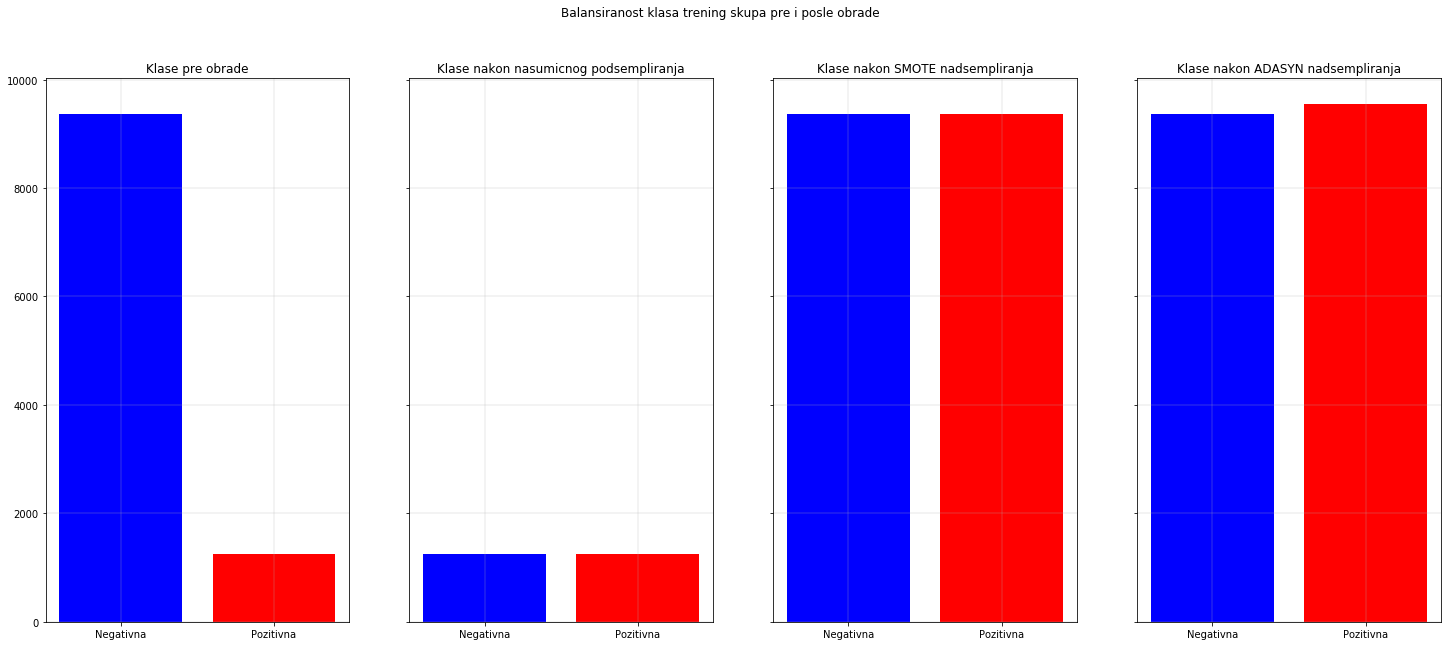

In [72]:
# Vizualizacija polaznih podataka trening skupa, zatim podataka nakon podsempliranja i nakon nadsempliranja

fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, sharey = True, figsize = (25, 10))
plt.suptitle ('Balansiranost klasa trening skupa pre i posle obrade')

ax1.set_title ('Klase pre obrade')
ax1.set_xticks (ticks = range (2))
ax1.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax1.bar ([0, 1], [sum(y_trening == 0), sum (y_trening == 1)], color = ['blue', 'red'])
ax1.grid (linewidth = 0.3)

ax2.set_title ('Klase nakon nasumicnog podsempliranja')
ax2.set_xticks (ticks = range (2))
ax2.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax2.bar ([0, 1], [sum(y_trening_pod == 0), sum (y_trening_pod == 1)], color = ['blue', 'red'])
ax2.grid (linewidth = 0.3)

ax3.set_title ('Klase nakon SMOTE nadsempliranja')
ax3.set_xticks (ticks = range (2))
ax3.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax3.bar ([0, 1], [sum(y_trening_nad_smote == 0), sum (y_trening_nad_smote == 1)], color = ['blue', 'red'])
ax3.grid (linewidth = 0.3)

ax4.set_title ('Klase nakon ADASYN nadsempliranja')
ax4.set_xticks (ticks = range (2))
ax4.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax4.bar ([0, 1], [sum(y_trening_nad_adasyn == 0), sum (y_trening_nad_adasyn == 1)], color = ['blue', 'red'])
ax4.grid (linewidth = 0.3)

plt.show()


In [ ]:
# Funkcija za lepo iscrtavanje matrice konfuzije
# Preuzeta i modifikovana za potrebe rada sa zvanicnog sajta biblioteke SciKit-Learn:
# https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html
def nacrtaj_matricu_konfuzije (y_test, y_procena, ime_modela):
    
    #plt.style.use ('dark_background')
    mat_konf = met.confusion_matrix(y_test, y_procena)
    
    # Kreiranje normalizovane verzije matrice konfuzije
    norm_mat_konf = mat_konf.astype('float') / mat_konf.sum(axis=1)[:, np.newaxis]
    
    klase = np.unique (np.hstack ((y_test, y_procena)))
    
    # Kreiranje grafika za svaku od matrica
    fig, (ax_1, ax_2) = plt.subplots (1, 2, figsize = (20, 10))
    plt.suptitle ('Matrice konfuzije za model: ' + ime_modela)
    
    slika_1 = ax_1.imshow (mat_konf, interpolation = 'nearest', cmap = 'Reds')
    ax_1.figure.colorbar (slika_1, ax = ax_1, shrink = 0.8)
    
    slika_2 = ax_2.imshow (norm_mat_konf, interpolation = 'nearest', cmap = 'Reds')
    ax_2.figure.colorbar (slika_2, ax = ax_2, shrink = 0.8)
    
    ax_1.set (xticks = np.arange (mat_konf.shape[1]),
              yticks = np.arange (mat_konf.shape[0]),
              xticklabels = klase,
              yticklabels = klase,
              title = 'Matrica konfuzije bez normalizacije',
              ylabel = 'Stvarne vrednosti',
              xlabel = 'Procenjene vrednosti')
    
    ax_2.set (xticks = np.arange (norm_mat_konf.shape[1]),
              yticks = np.arange (norm_mat_konf.shape[0]),
              xticklabels = klase,
              yticklabels = klase,
              title = 'Normalizovana matrica konfuzije',
              ylabel = 'Stvarne vrednosti',
              xlabel = 'Procenjene vrednosti')
    
    # Potrebno zbog baga u trenutnoj verziji Matplotlib-a 3.1.1, izbrisati nakon nadogradnje
    # Bag: https://github.com/matplotlib/matplotlib/issues/15154
    ################################################################
    ax_1.set_ylim (mat_konf.shape[0] - 0.5, -0.5)
    ax_2.set_ylim (norm_mat_konf.shape[0] - 0.5, -0.5)
    ################################################################
    
    plt.setp (ax_1.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    plt.setp (ax_2.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    
    tekst = [['Stvarno negativni\n','Lazno pozitivni\n'], ['Lazno negativni\n', 'Stvarno pozitivni\n']]
    
    for i in range (mat_konf.shape[0]):
        for j in range(mat_konf.shape[1]):
            ax_1.text (j, i, str (tekst[i][j]) + format(mat_konf[i, j], 'g'), horizontalalignment = 'center', verticalalignment = 'center', bbox = dict (facecolor = 'gray', alpha = 0.9))
            ax_2.text (j, i, str (tekst[i][j]) + format(norm_mat_konf[i, j], 'g'), horizontalalignment = 'center', verticalalignment = 'center', bbox = dict (facecolor = 'gray', alpha = 0.9))
    
    fig.tight_layout()
    
    return ax_1, ax_2


# 3. Primena modela potpornih vektora u cilju resavanja problema klasifikacije nad razlicito balansiranim polaznim skupom podataka
U nastavku ce se uvek primenjivati metod potpornih vektora za klasifikaciju ali nad razlicito balansiranim skupovima podataka i to u sledecem redosledu:
* 3.1. Polazni skup podataka nad kojim nisu primenjene eksplicitne tehnike balansiranja
    * 3.1.1 Linearni model potpornih vektora bez ukljucenog class_weight parametra (koji uzima u obzir nebalansiranost klasa pri ucenju)
    * 3.1.2 Linearni model potpornih vektora sa ukljucenim class_weight parametrom (koji uzima u obzir nebalansiranost klasa pri ucenju)
    * 3.1.3 Kernelizovan model potpornih vektora bez ukljucenog class_weight parametra (koji uzima u obzir nebalansiranost klasa pri ucenju)
    * 3.1.4 Kernelizovan model potpornih vektora sa ukljucenim class_weight parametrom (koji uzima u obzir nebalansiranost klasa pri ucenju)
* 3.2. Polazni skup podataka koji je balansiran nasumicnim podsempliranjem
    * 3.2.1 Linearni model potpornih vektora
    * 3.2.2 Kernelizovan model potpornih vektora
* 3.3. Polazni skup podataka koji je balansiran nadsempliranjem SMOTE algoritmom
    * 3.3.1 Linearni model potpornih vektora
    * 3.3.2 Kernelizovan model potpornih vektora


3.1. sadrzi modele u kojima je aktiviran class_weight parametar na 'balanced' vrednost cisto radi uporedjivanja uspesnosti modela pri razlicitim tehnikama prevazilazenja nebalansiranih klasa.
Ovaj parametar na osnovu zvanicne dokumentacije radi sledece:
* The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

Te je zelja da se iskoristi i ova mogucnost i ispita uspesnost modela i kada se ona aktivira.
U delovim 3.2. i 3.3. se taj parametar ne aktivira jer su nam klase eksplicitno balansirane metodama podsempliranja i nadsempliranja te aktiviranje ovog parametra nece dati nikakav efekat.

#### Par reci o parametrima modela potpornih vektora
* Treba primetiti da se model trenira tako da se prati 'f1' mera. Ovo je kljucna stavka prilikom rada sa podacima u kojima su klase nebalansirane, jer preciznost i tacnost nece dati pravu uspesnost naseg modela pri klasifikaciji manjinske klase.
* Broj iteracija kod linearne verzije je takodje odabran tako da se dostigne konvergencija u vecini slucajeva, do ovog broja sam dosao visestrukim testiranjem
* Broj slojeva kros-validacije je najvise ogranicen jacinom mog racunara. U linearnoj verziji je on stavljen na 10, jer je vreme trazenja najboljih parametara ne toliko zahtevan posao, dok kod kernelizovane verzije je on samo 3, jer se ispituje mnogo vise parametara te ova vrednost daje razumno vreme rada procesora
* Kod kernelizovanih modela se isprobavaju, kao parametri, svi dostupni kerneli same biblioteke


## 3.1. Polazni skup podataka nad kojim nisu primenjene tehnike balansiranja
### 3.1.1 Linearni model potpornih vektora bez ukljucenog class_weight parametra (koji uzima u obzir nebalansiranost klasa pri ucenju)

In [ ]:
# Definisanje globalnih parametara
cv_kern = 5
n_jobs_kern = -1
max_iter_lin = 10000


In [75]:
# Za svaku od verzija podataka, isprobavanje razlicitih modela masinskog ucenja
# Za pocetak koristim samo SVM (metod potpornih vektora, sa razlicitim kernelima, ukljucujuci i linearni oblik)

# Definisanje metaparametara linearnog modela
parametri_lin = {'C': [10**i for i in range (-5, 5)]}

# Linearni model potpornih vektora bez aktiviranog ugradjeno parametra class_weight
mpv_lin_nebal = ms.GridSearchCV (svm.LinearSVC (random_state = 7, class_weight = None, max_iter = max_iter_lin), param_grid = parametri_lin, scoring = 'f1', n_jobs = 1, cv = 10, verbose = 1)
mpv_lin_nebal.fit (x_trening, y_trening)
y_procena = mpv_lin_nebal.predict (x_test)

print ('Parametri najboljeg modela:', mpv_lin_nebal.best_params_)
print ('Izvestaj klasifikacije linearnog mpv-a:\n', met.classification_report (y_test, y_procena))


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, incre

Parametri najboljeg modela: {'C': 1e-05}
Izvestaj klasifikacije linearnog mpv-a:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      4612
           1       0.55      0.53      0.54       615

    accuracy                           0.89      5227
   macro avg       0.74      0.74      0.74      5227
weighted avg       0.89      0.89      0.89      5227



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.8min finished


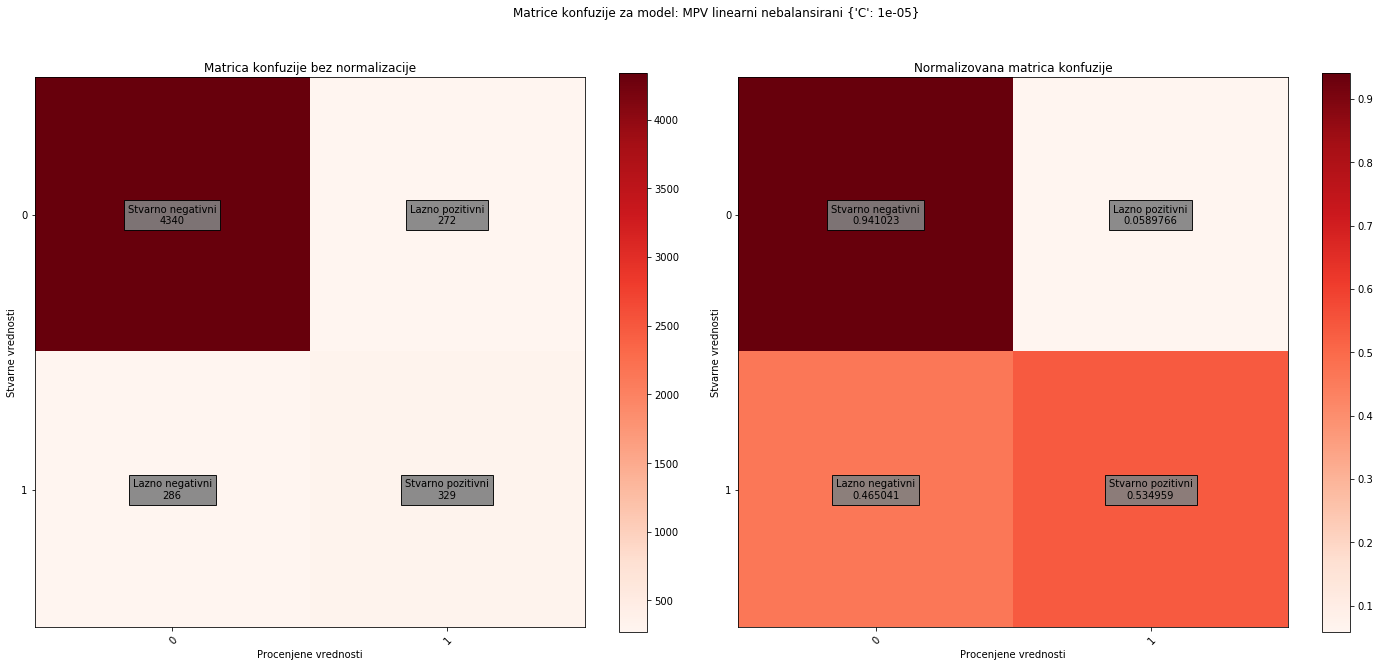

In [76]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV linearni nebalansirani ' + str (mpv_lin_nebal.best_params_))
plt.show()


### 3.1.2 Linearni model potpornih vektora sa ukljucenim class_weight parametrom (koji uzima u obzir nebalansiranost klasa pri ucenju)

In [77]:
# Linearni model potpornih vektora sa balansiranim klasama pomocu ugradjenog parametra
mpv_lin_bal = ms.GridSearchCV (svm.LinearSVC (random_state = 7, class_weight = 'balanced', max_iter = max_iter_lin), param_grid = parametri_lin, scoring = 'f1', n_jobs = 1, cv = 10, verbose = 1)
mpv_lin_bal.fit (x_trening, y_trening)
y_procena = mpv_lin_bal.predict (x_test)

print ('Parametri najboljeg modela:', mpv_lin_bal.best_params_)
print ('Izvestaj klasifikacije linearnog mpv-a:\n', met.classification_report (y_test, y_procena))


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, incre

Parametri najboljeg modela: {'C': 100}
Izvestaj klasifikacije linearnog mpv-a:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      4612
           1       0.48      0.69      0.56       615

    accuracy                           0.88      5227
   macro avg       0.72      0.79      0.75      5227
weighted avg       0.90      0.88      0.88      5227



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


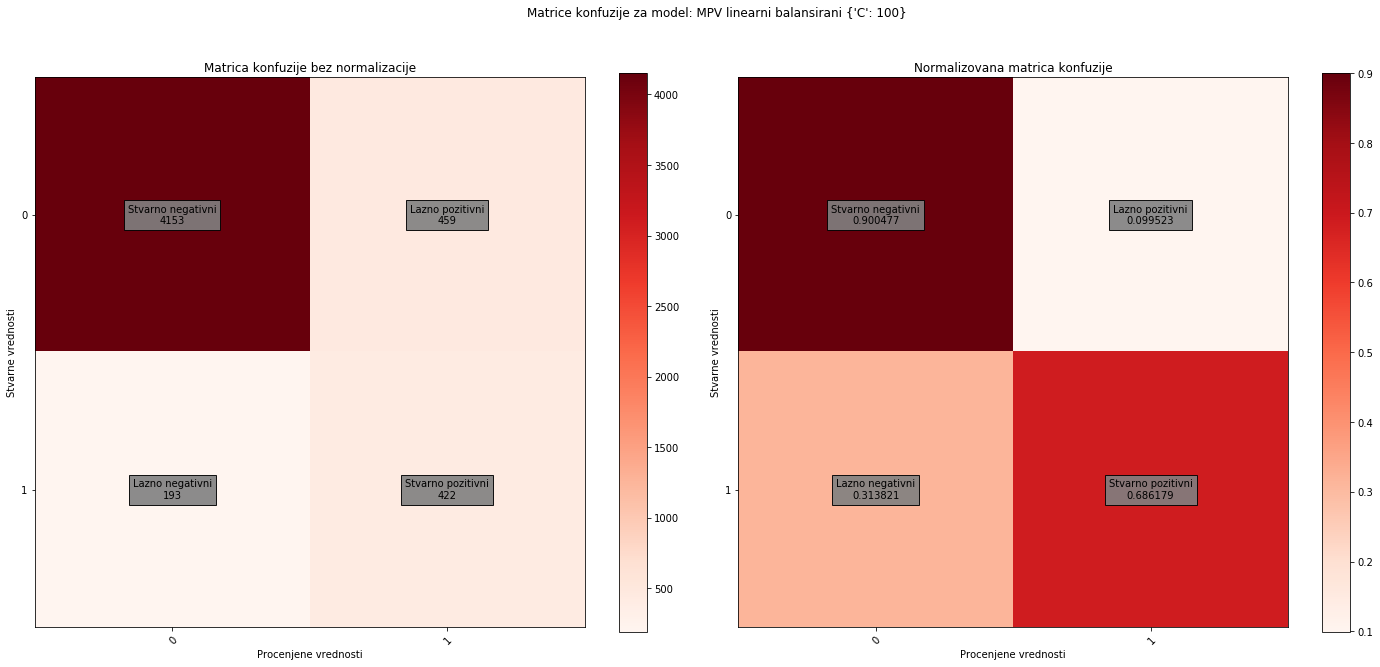

In [78]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV linearni balansirani ' + str (mpv_lin_bal.best_params_))
plt.show()


### 3.1.3 Kernelizovan model potpornih vektora bez ukljucenog class_weight parametra (koji uzima u obzir nebalansiranost klasa pri ucenju)

In [79]:
# Definisanje metaparametara kernelizovanog modela
parametri_kern = {'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': [10**i for i in range(-5, 5)], 'C': [10**i for i in range (-5, 5)]}

# Kernelizovani model potpornih vektora bez aktiviranog ugradjeno parametra class_weight
mpv_kern_nebal = ms.GridSearchCV (svm.SVC(class_weight = None, random_state = 7), param_grid = parametri_kern, scoring = 'f1', n_jobs = n_jobs_kern, cv = cv_kern, verbose = 2)
mpv_kern_nebal.fit (x_trening, y_trening)
y_procena = mpv_kern_nebal.predict (x_test)

print ('Parametri najboljeg modela:', mpv_kern_nebal.best_params_)
print ('Izvestaj klasifikacije kernelizovanog mpv-a:\n', met.classification_report (y_test, y_procena))


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 11.4min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 87.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 93.2min finished


Parametri najboljeg modela: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Izvestaj klasifikacije kernelizovanog mpv-a:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      4612
           1       0.88      0.68      0.77       615

    accuracy                           0.95      5227
   macro avg       0.92      0.83      0.87      5227
weighted avg       0.95      0.95      0.95      5227



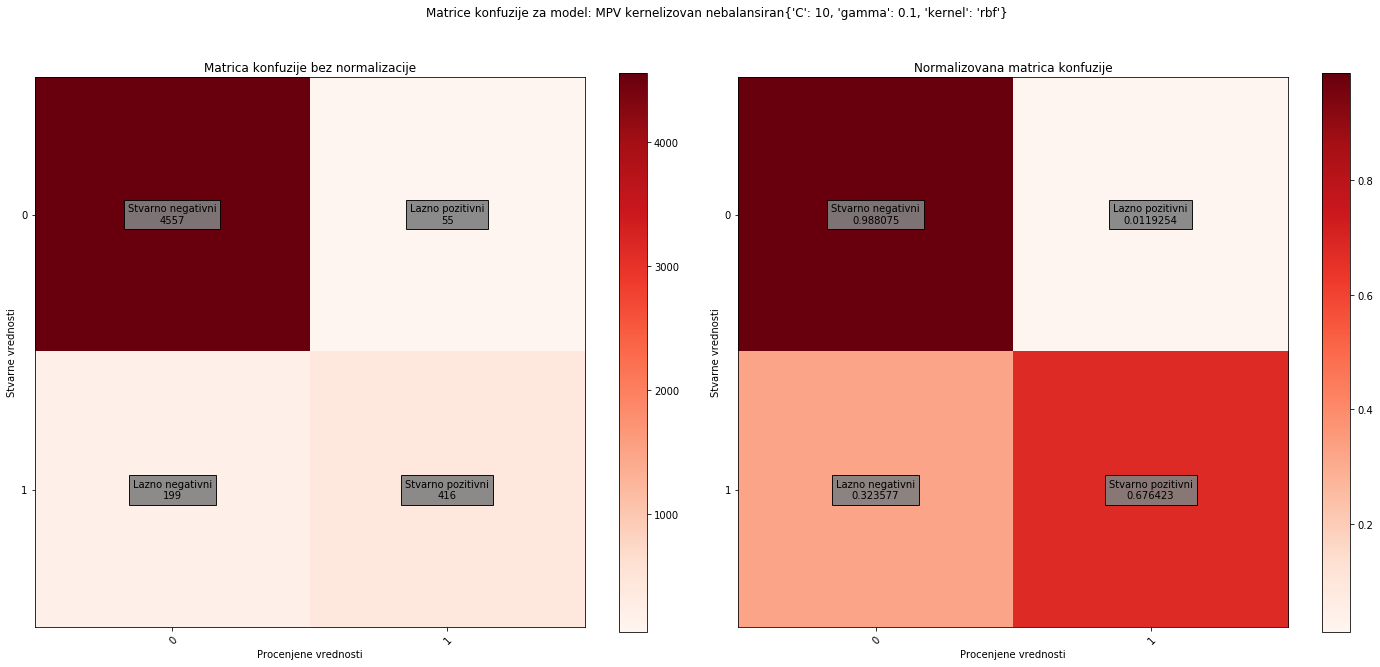

In [80]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV kernelizovan nebalansiran' + str (mpv_kern_nebal.best_params_))
plt.show()

In [ ]:
# Cuvanje rezultata kros-validacije u .csv fajl
putanja_za_rezultate = os.path.join ('..', 'data', 'Rezultati_Uniprot_cist')

df_mpv_kern_nebal = pd.DataFrame (mpv_kern_nebal.cv_results_)
df_mpv_kern_nebal.to_csv (os.path.join (putanja_za_rezultate, 'MPV_KERN_NEBAL.csv'))
#df_mpv_kern_nebal


### 3.1.4 Kernelizovan model potpornih vektora sa ukljucenim class_weight parametrom (koji uzima u obzir nebalansiranost klasa pri ucenju)

In [84]:
# Kernelizovani model potpornih vektora sa balansiranim klasama pomocu ugradjenog parametra

mpv_kern_bal = ms.GridSearchCV (svm.SVC(class_weight = 'balanced', random_state = 7), param_grid = parametri_kern, scoring = 'f1', n_jobs = n_jobs_kern, cv = cv_kern, verbose = 2)
mpv_kern_bal.fit (x_trening, y_trening)
y_procena = mpv_kern_bal.predict (x_test)

print ('Parametri najboljeg modela:', mpv_kern_bal.best_params_)
print ('Izvestaj klasifikacije kernelizovanog mpv-a:\n', met.classification_report (y_test, y_procena))


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 61.9min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 95.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 142.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 148.4min finished


Parametri najboljeg modela: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Izvestaj klasifikacije kernelizovanog mpv-a:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      4612
           1       0.89      0.68      0.77       615

    accuracy                           0.95      5227
   macro avg       0.92      0.84      0.87      5227
weighted avg       0.95      0.95      0.95      5227



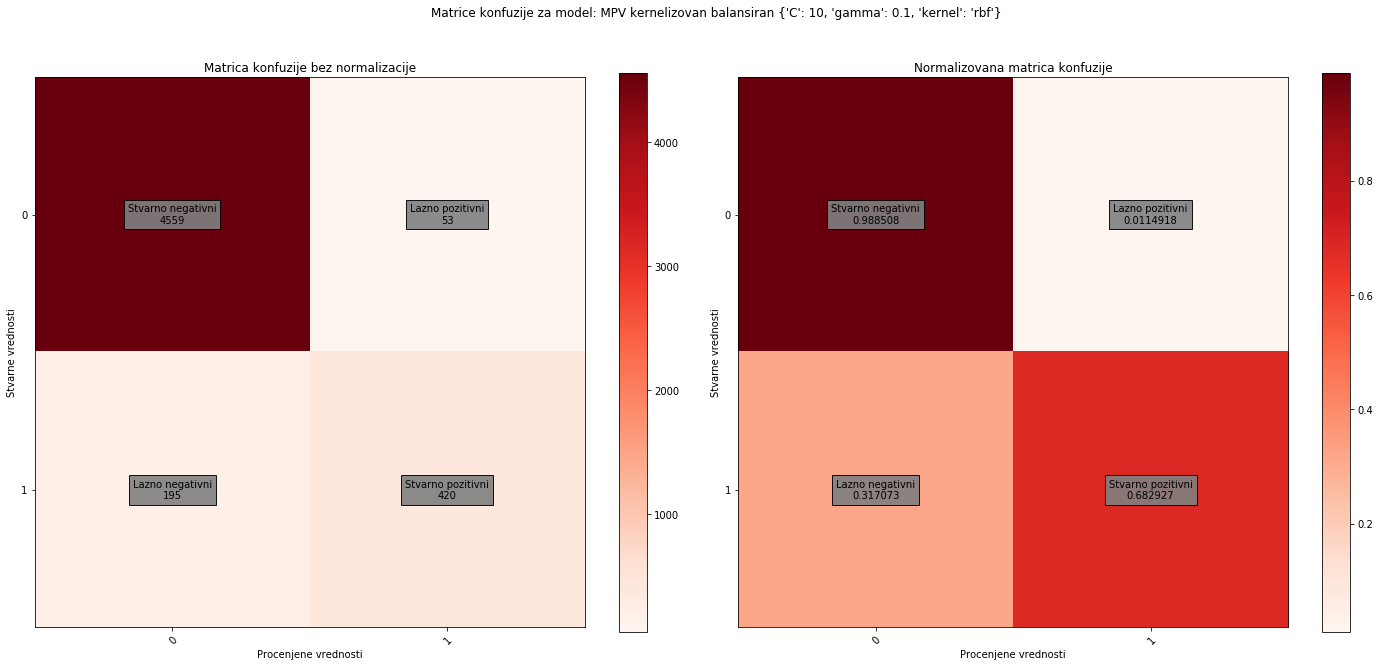

In [85]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV kernelizovan balansiran ' + str (mpv_kern_bal.best_params_))
plt.show()

In [ ]:
# Cuvanje rezultata kros-validacije u .csv fajl

df_mpv_kern_bal = pd.DataFrame (mpv_kern_bal.cv_results_)
df_mpv_kern_bal.to_csv (os.path.join (putanja_za_rezultate, 'MPV_KERN_BAL.csv'))
#df_mpv_kern_bal


## 3.2. Polazni skup podataka koji je balansiran nasumicnim podsempliranjem
### 3.2.1 Linearni model potpornih vektora

In [87]:
# Definisanje metaparametara linearnog modela
parametri_lin = {'C': [10**i for i in range (-5, 5)]}

# Linearni model potpornih vektora bez aktiviranog ugradjeno parametra class_weight
mpv_lin_bal_pod = ms.GridSearchCV (svm.LinearSVC (random_state = 7, class_weight = None, max_iter = max_iter_lin), param_grid = parametri_lin, scoring = 'f1', n_jobs = 1, cv = 10, verbose = 1)
mpv_lin_bal_pod.fit (x_trening_pod, y_trening_pod)
y_procena = mpv_lin_bal_pod.predict (x_test)

print ('Parametri najboljeg modela:', mpv_lin_bal_pod.best_params_)
print ('Izvestaj klasifikacije linearnog mpv-a:\n', met.classification_report (y_test, y_procena))


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, incre

Parametri najboljeg modela: {'C': 0.001}
Izvestaj klasifikacije linearnog mpv-a:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85      4612
           1       0.32      0.86      0.47       615

    accuracy                           0.77      5227
   macro avg       0.65      0.81      0.66      5227
weighted avg       0.90      0.77      0.81      5227



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


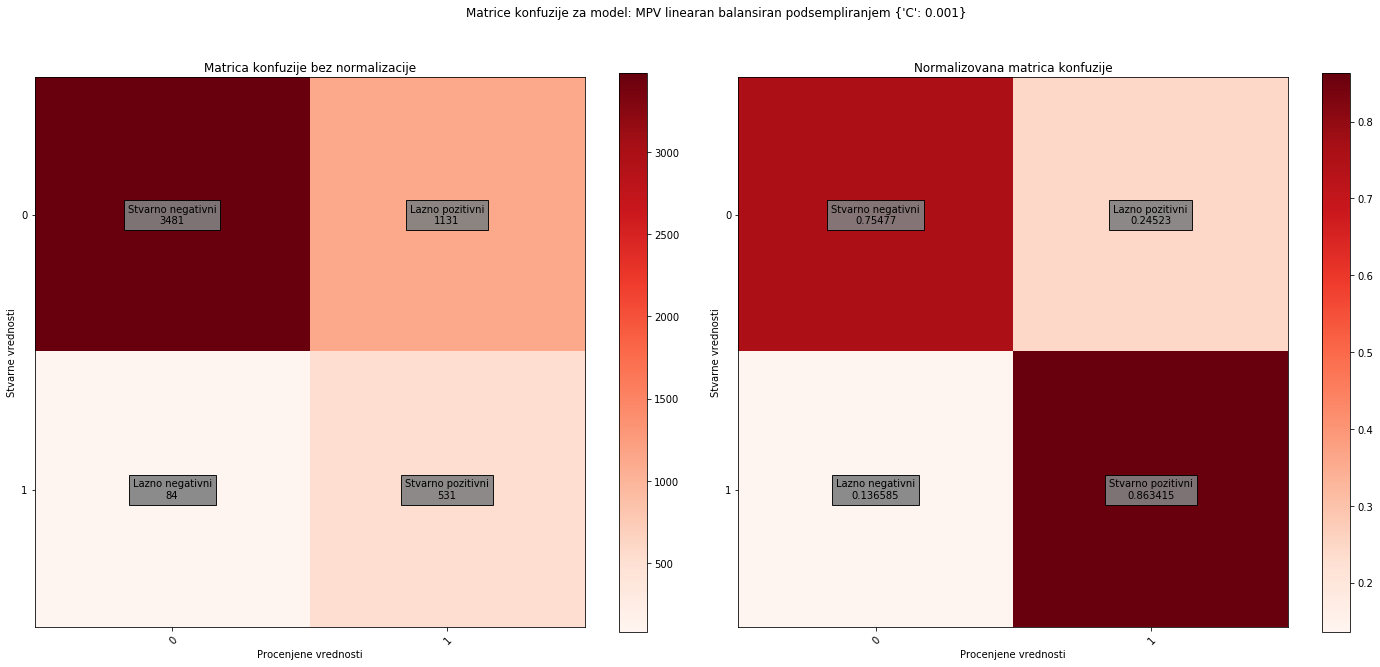

In [88]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV linearan balansiran podsempliranjem ' + str (mpv_lin_bal_pod.best_params_))
plt.show()

In [ ]:
# Cuvanje rezultata kros-validacije u .csv fajl

df_mpv_lin_bal_pod = pd.DataFrame (mpv_lin_bal_pod.cv_results_)
df_mpv_lin_bal_pod.to_csv (os.path.join (putanja_za_rezultate, 'MPV_LIN_BAL_POD.csv'))
#df_mpv_lin_bal_pod


### 3.2.2 Kernelizovan model potpornih vektora

In [90]:
# Definisanje metaparametara kernelizovanog modela
parametri_kern = {'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': [10**i for i in range(-5, 5)], 'C': [10**i for i in range (-5, 5)]}

# Kernelizovani model potpornih vektora bez aktiviranog ugradjeno parametra class_weight
mpv_kern_bal_pod = ms.GridSearchCV (svm.SVC(class_weight = None, random_state = 7), param_grid = parametri_kern, scoring = 'f1', n_jobs = n_jobs_kern, cv = cv_kern, verbose = 2)
mpv_kern_bal_pod.fit (x_trening_pod, y_trening_pod)
y_procena = mpv_kern_bal_pod.predict (x_test)

print ('Parametri najboljeg modela:', mpv_kern_bal_pod.best_params_)
print ('Izvestaj klasifikacije kernelizovanog mpv-a:\n', met.classification_report (y_test, y_procena))


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  6.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Parametri najboljeg modela: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Izvestaj klasifikacije kernelizovanog mpv-a:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94      4612
           1       0.55      0.85      0.67       615

    accuracy                           0.90      5227
   macro avg       0.77      0.88      0.81      5227
weighted avg       0.93      0.90      0.91      5227



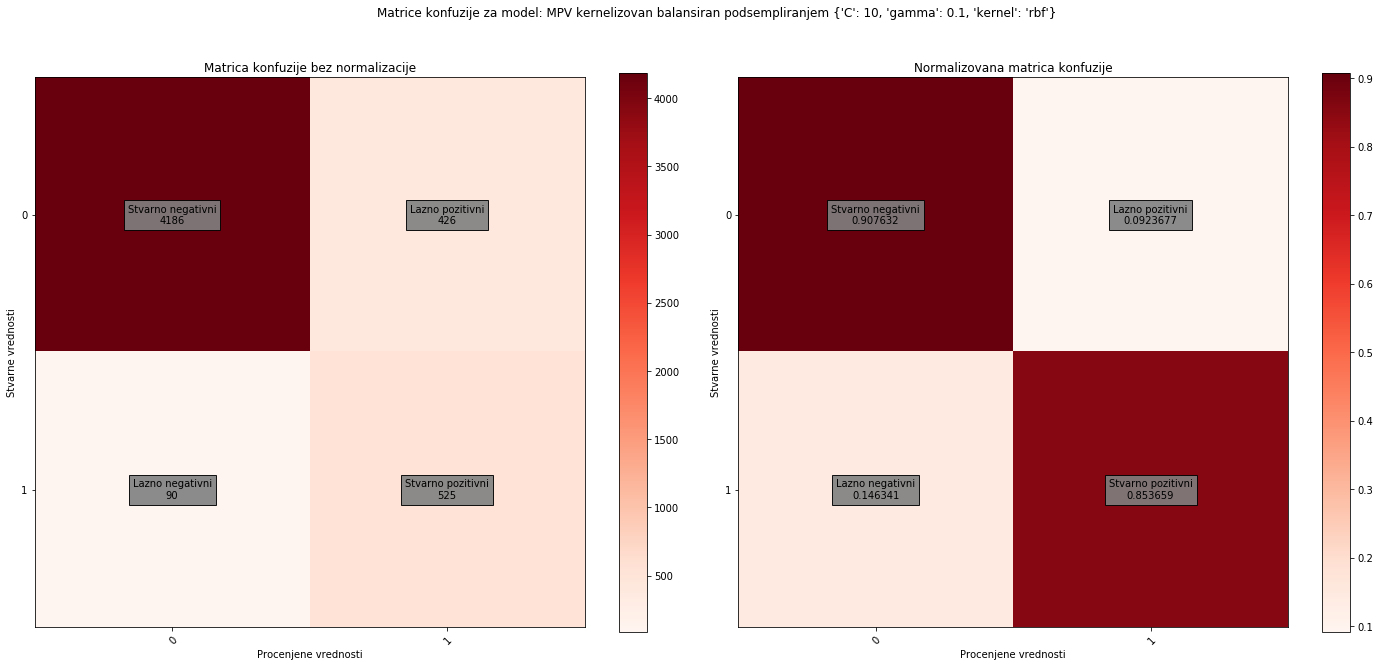

In [91]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV kernelizovan balansiran podsempliranjem ' + str (mpv_kern_bal_pod.best_params_))
plt.show()

In [ ]:
# Cuvanje rezultata kros-validacije u .csv fajl

df_mpv_kern_bal_pod = pd.DataFrame (mpv_kern_bal_pod.cv_results_)
df_mpv_kern_bal_pod.to_csv (os.path.join (putanja_za_rezultate, 'MPV_KERN_BAL_POD.csv'))
#df_mpv_kern_bal_pod


## 3.3. Polazni skup podataka koji je balansiran nadsempliranjem SMOTE algoritmom
### 3.3.1 Linearni model potpornih vektora

In [93]:
# Definisanje metaparametara linearnog modela
parametri_lin = {'C': [10**i for i in range (-5, 5)]}

# Linearni model potpornih vektora bez aktiviranog ugradjeno parametra class_weight
mpv_lin_bal_nad_smote = ms.GridSearchCV (svm.LinearSVC (random_state = 7, class_weight = None, max_iter = max_iter_lin), param_grid = parametri_lin, scoring = 'f1', n_jobs = 1, cv = 10, verbose = 1)
mpv_lin_bal_nad_smote.fit (x_trening_nad_smote, y_trening_nad_smote)
y_procena = mpv_lin_bal_nad_smote.predict (x_test)

print ('Parametri najboljeg modela:', mpv_lin_bal_nad_smote.best_params_)
print ('Izvestaj klasifikacije linearnog mpv-a:\n', met.classification_report (y_test, y_procena))


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, incre

Parametri najboljeg modela: {'C': 0.001}
Izvestaj klasifikacije linearnog mpv-a:
               precision    recall  f1-score   support

           0       0.97      0.81      0.88      4612
           1       0.36      0.81      0.50       615

    accuracy                           0.81      5227
   macro avg       0.67      0.81      0.69      5227
weighted avg       0.90      0.81      0.84      5227



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 33.7min finished


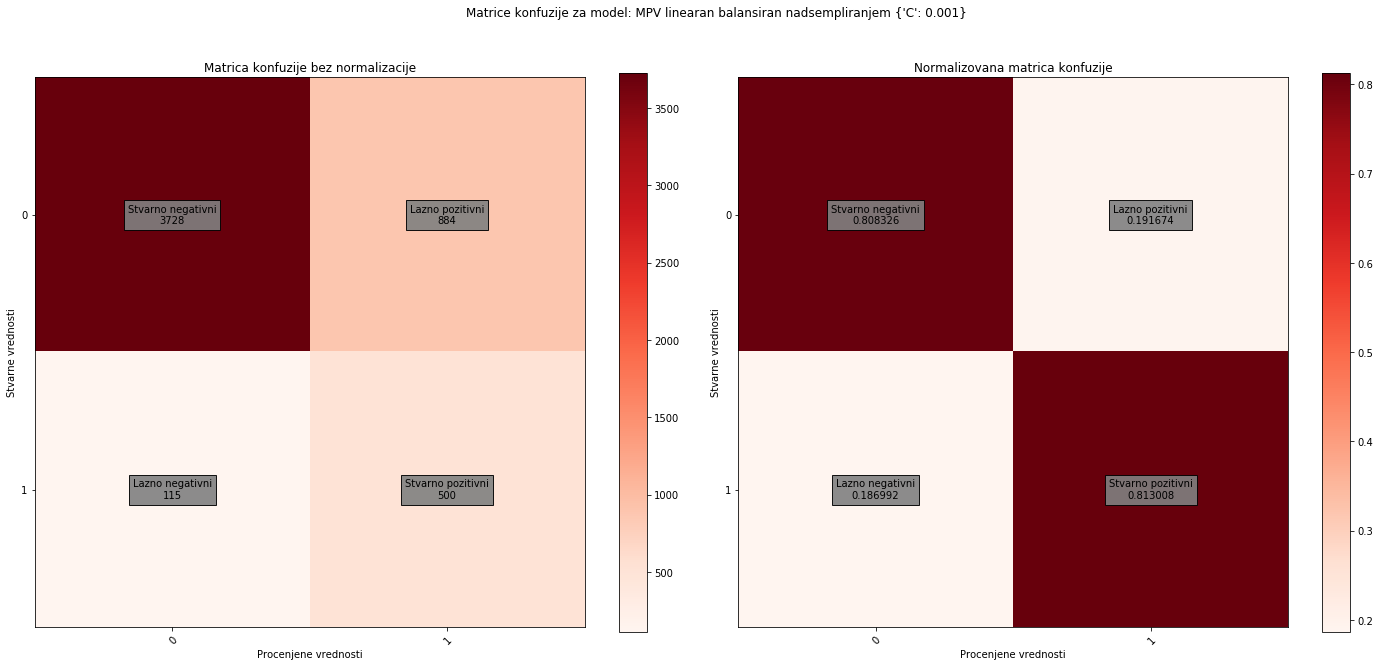

In [94]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV linearan balansiran nadsempliranjem ' + str (mpv_lin_bal_nad_smote.best_params_))
plt.show()

In [ ]:
# Cuvanje rezultata kros-validacije u .csv fajl

df_mpv_lin_bal_nad_smote = pd.DataFrame (mpv_lin_bal_nad_smote.cv_results_)
df_mpv_lin_bal_nad_smote.to_csv (os.path.join (putanja_za_rezultate, 'MPV_LIN_BAL_NAD_SMOTE.csv'))
#df_mpv_lin_bal_nad_smote


### 3.3.2 Kernelizovan model potpornih vektora

In [ ]:
# Definisanje metaparametara kernelizovanog modela
parametri_kern = {'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': [10**i for i in range(-5, 5)], 'C': [10**i for i in range (-5, 5)]}

# Kernelizovani model potpornih vektora bez aktiviranog ugradjeno parametra class_weight
mpv_kern_bal_nad_smote = ms.GridSearchCV (svm.SVC(class_weight = None, random_state = 7), param_grid = parametri_kern, scoring = 'f1', n_jobs = n_jobs_kern, cv = cv_kern, verbose = 2)
mpv_kern_bal_nad_smote.fit (x_trening_nad_smote, y_trening_nad_smote)
y_procena = mpv_kern_bal_nad_smote.predict (x_test)

print ('Parametri najboljeg modela:', mpv_kern_bal_nad_smote.best_params_)
print ('Izvestaj klasifikacije kernelizovanog mpv-a:\n', met.classification_report (y_test, y_procena))


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 50.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 113.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 198.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 314.7min


In [ ]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV kernelizovan balansiran nadsempliranjem ' + str (mpv_kern_bal_nad_smote.best_params_))
plt.show()

In [ ]:
# Cuvanje rezultata kros-validacije u .csv fajl
putanja_za_rezultate = os.path.join ('..', 'data', 'Rezultati_Uniprot_cist')

df_mpv_kern_bal_nad_smote = pd.DataFrame (mpv_kern_bal_nad_smote.cv_results_)
df_mpv_kern_bal_nad_smote.to_csv (os.path.join (putanja_za_rezultate, 'MPV_KERN_BAL_NAD_SMOTE.csv'))
#df_mpv_kern_bal_nad_smote


## 3.4. Polazni skup podataka koji je balansiran nadsempliranjem ADASYN algoritmom
### 3.4.1 Linearni model potpornih vektora

In [ ]:
# Definisanje metaparametara linearnog modela
parametri_lin = {'C': [10**i for i in range (-5, 5)]}

# Linearni model potpornih vektora bez aktiviranog ugradjeno parametra class_weight
mpv_lin_bal_nad_adasyn = ms.GridSearchCV (svm.LinearSVC (random_state = 7, class_weight = None, max_iter = max_iter_lin), param_grid = parametri_lin, scoring = 'f1', n_jobs = 1, cv = 10, verbose = 1)
mpv_lin_bal_nad_adasyn.fit (x_trening_nad_adasyn, y_trening_nad_adasyn)
y_procena = mpv_lin_bal_nad_adasyn.predict (x_test)

print ('Parametri najboljeg modela:', mpv_lin_bal_nad_adasyn.best_params_)
print ('Izvestaj klasifikacije linearnog mpv-a:\n', met.classification_report (y_test, y_procena))


In [ ]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV linearan balansiran nadsempliranjem ' + str (mpv_lin_bal_nad_adasyn.best_params_))
plt.show()

In [ ]:
# Cuvanje rezultata kros-validacije u .csv fajl

df_mpv_lin_bal_nad_adasyn = pd.DataFrame (mpv_lin_bal_nad_adasyn.cv_results_)
df_mpv_lin_bal_nad_adasyn.to_csv (os.path.join (putanja_za_rezultate, 'MPV_LIN_BAL_NAD_ADASYN.csv'))
#df_mpv_lin_bal_nad_adasyn


### 3.3.2 Kernelizovan model potpornih vektora

In [ ]:
# Definisanje metaparametara kernelizovanog modela
parametri_kern = {'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': [10**i for i in range(-5, 5)], 'C': [10**i for i in range (-5, 5)]}

# Kernelizovani model potpornih vektora bez aktiviranog ugradjeno parametra class_weight
mpv_kern_bal_nad_adasyn = ms.GridSearchCV (svm.SVC(class_weight = None, random_state = 7), param_grid = parametri_kern, scoring = 'f1', n_jobs = n_jobs_kern, cv = cv_kern, verbose = 2)
mpv_kern_bal_nad_adasyn.fit (x_trening_nad_adasyn, y_trening_nad_adasyn)
y_procena = mpv_kern_bal_nad_adasyn.predict (x_test)

print ('Parametri najboljeg modela:', mpv_kern_bal_nad_adasyn.best_params_)
print ('Izvestaj klasifikacije kernelizovanog mpv-a:\n', met.classification_report (y_test, y_procena))


In [ ]:
# Iscrtavanje matrice konfuzije za prethodni model
nacrtaj_matricu_konfuzije (y_test, y_procena, 'MPV kernelizovan balansiran nadsempliranjem ' + str (mpv_kern_bal_nad_adasyn.best_params_))
plt.show()

In [ ]:
# Cuvanje rezultata kros-validacije u .csv fajl
putanja_za_rezultate = os.path.join ('..', 'data', 'Rezultati_Uniprot_cist')

df_mpv_kern_bal_nad_adasyn = pd.DataFrame (mpv_kern_bal_nad_adasyn.cv_results_)
df_mpv_kern_bal_nad_adasyn.to_csv (os.path.join (putanja_za_rezultate, 'MPV_KERN_BAL_NAD_ADASYN.csv'))
df_mpv_kern_bal_nad_adasyn
